In [1]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage
import skimage
from skimage import io
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_ubyte

import cv2
from albumentations import (
    Compose, HorizontalFlip, ShiftScaleRotate, ElasticTransform,
    RandomBrightness, RandomContrast, RandomGamma, CLAHE
)

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import telebot
import time
import tensorflow as tf
from tensorflow import keras

import lime
from lime import lime_image

import pandas as pd

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
  try:
    print("gpus existem")
    print(gpus)
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)
    
    
TELEBOT_TOKEN = "2058519653:AAG5Kf0Othtye8e13F5WPnBQQSdoCt47ifA"

bot = telebot.TeleBot("2058519653:AAG5Kf0Othtye8e13F5WPnBQQSdoCt47ifA")
bot.config['api_key'] = TELEBOT_TOKEN
bot.get_me()

gpus existem
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


{'ok': True,
 'result': {'id': 2058519653,
  'is_bot': True,
  'first_name': 'cnn_covid',
  'username': 'cnn_covid_bot',
  'can_join_groups': True,
  'can_read_all_group_messages': False,
  'supports_inline_queries': False}}

## Load Datasets


In [2]:
X_val = np.load('input/X_val.npy')
Y_val = np.load('input/Y_val.npy')

X_train = np.load('input/X_train.npy')
Y_train = np.load('input/Y_train.npy')

X_test = np.load('input/X_test.npy')
Y_test = np.load('input/Y_test.npy')

steps_per_epoch = 321

## Load Model

In [3]:
tf.keras.backend.clear_session()
model_name = "cache/tl_vgg16_finetune_cd.h5"
model = keras.models.load_model(model_name)

## Eval Train

In [4]:
train1, train2, train3, train4 = np.array_split(X_train, 4)

train1 = np.stack((train1,) * 3, axis= -1)
train2 =  np.stack((train2,) * 3, axis= -1)
train3 =  np.stack((train3,) * 3, axis= -1)
train4 = np.stack((train4,) * 3, axis= -1)

del(X_train)

In [5]:
Y_pred = model.predict(train1, batch_size=16)
del(train1)

In [6]:
Y_pred1 = model.predict(train2, batch_size=16)
del(train2)

In [7]:
Y_pred2 = model.predict(train3, batch_size=16)
del(train3)

In [8]:
Y_pred3 = model.predict(train4, batch_size=16)
del(train4)

In [9]:
y_pred = np.concatenate((Y_pred, Y_pred1, Y_pred2, Y_pred3))
del(Y_pred, Y_pred1, Y_pred2, Y_pred3)

Confusion Matrix


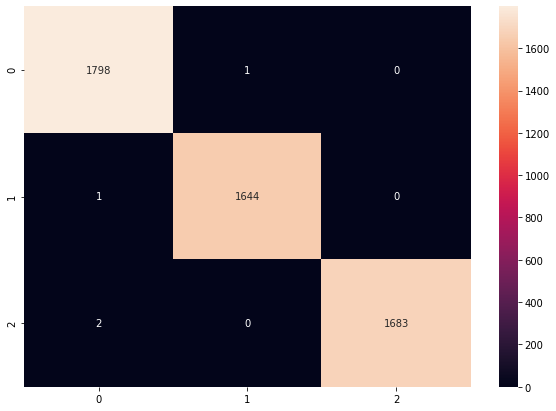

Classification Report
              precision    recall  f1-score   support

     Opacity       1.00      1.00      1.00      1799
    COVID-19       1.00      1.00      1.00      1645
      Normal       1.00      1.00      1.00      1685

    accuracy                           1.00      5129
   macro avg       1.00      1.00      1.00      5129
weighted avg       1.00      1.00      1.00      5129

F-Score
(0.9992421186698598, 0.9992164297583885, 0.9992290539750993, None)
Accuracy
0.9992201208812634


In [10]:
y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(Y_train, axis = 1)
print('Confusion Matrix')
df_cm_train = metrics.confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_train, annot=True, fmt='.4g')
plt.show()
print('Classification Report')
class_repo_train = metrics.classification_report(y_true, y_pred, output_dict=True, target_names = ["Opacity", "COVID-19", "Normal"])
print(metrics.classification_report(y_true, y_pred, target_names = ["Opacity", "COVID-19", "Normal"]))
print('F-Score')
f_score_train = metrics.precision_recall_fscore_support(y_true, y_pred, average = "macro")
print(f_score_train)
print("Accuracy")
acc_train = metrics.accuracy_score(y_true, y_pred)
print(acc_train)

## Eval Val

Confusion Matrix


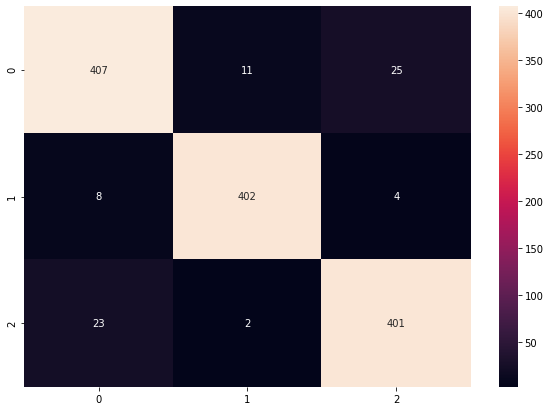

Classification Report
              precision    recall  f1-score   support

     Opacity       0.93      0.92      0.92       443
    COVID-19       0.97      0.97      0.97       414
      Normal       0.93      0.94      0.94       426

    accuracy                           0.94      1283
   macro avg       0.94      0.94      0.94      1283
weighted avg       0.94      0.94      0.94      1283

F-Score
(0.9434855275407673, 0.943688312797363, 0.943569709721289, None)
Accuracy
0.9431021044427124


In [11]:
Y_pred = model.predict(X_val, batch_size = 16)
y_pred = np.argmax(Y_pred, axis = 1)
y_true = np.argmax(Y_val, axis = 1)
print('Confusion Matrix')
df_cm_val = metrics.confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_val, annot=True, fmt='.3g')
plt.show()
print('Classification Report')
class_repo_val = metrics.classification_report(y_true, y_pred, output_dict=True, target_names = ["Opacity", "COVID-19", "Normal"])
print(metrics.classification_report(y_true, y_pred, target_names = ["Opacity", "COVID-19", "Normal"]))
print('F-Score')
f_score_val = metrics.precision_recall_fscore_support(y_true, y_pred, average = "macro")
print(f_score_val)
print("Accuracy")
acc_val = metrics.accuracy_score(y_true, y_pred)
print(acc_val)

## Eval Test

Confusion Matrix


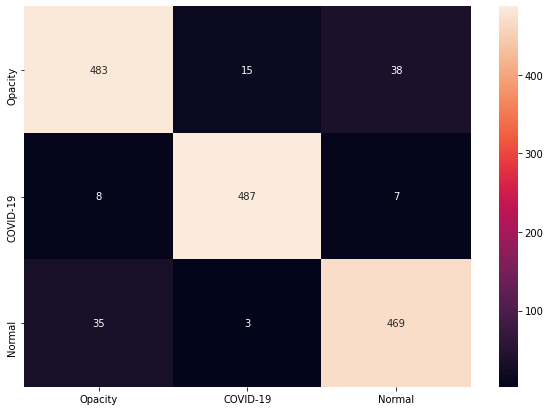

Classification Report
              precision    recall  f1-score   support

     Opacity       0.92      0.90      0.91       536
    COVID-19       0.96      0.97      0.97       502
      Normal       0.91      0.93      0.92       507

    accuracy                           0.93      1545
   macro avg       0.93      0.93      0.93      1545
weighted avg       0.93      0.93      0.93      1545

F-Score
(0.931686249360537, 0.9320960781873732, 0.9318470212891382, None)
Accuracy
0.9313915857605178


In [12]:
start = time.time()

Y_pred = model.predict(X_test, batch_size = 16)
y_pred = np.argmax(Y_pred, axis = 1)
y_true = np.argmax(Y_test, axis = 1)

print('Confusion Matrix')
df_cm_test = metrics.confusion_matrix(y_true, y_pred)
cm_labels = ["Opacity", "COVID-19", "Normal"]
cm_array = df_cm_test
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
plt.figure(figsize = (10,7))
sns.heatmap(cm_array_df, annot=True, fmt='.3g') 
plt.show()

print('Classification Report')
class_repo_test = metrics.classification_report(y_true, y_pred, output_dict=True, target_names = ["Opacity", "COVID-19", "Normal"])
print(metrics.classification_report(y_true, y_pred, target_names = ["Opacity", "COVID-19", "Normal"]))
print('F-Score')
f_score_test = metrics.precision_recall_fscore_support(y_true, y_pred, average = "macro")
print(f_score_test)
print("Accuracy")
acc_test = metrics.accuracy_score(y_true, y_pred)
print(acc_test)

end = time.time()

final_test = end-start

## Eval Test 2 

In [13]:
tf.keras.backend.clear_session()
model_name = "cache/tl_vgg16_finetune_cd.h5"
model = keras.models.load_model(model_name)

X_test2 = np.load('input/X_test2.npy')
Y_test2 = np.load('input/Y_test2.npy')


Confusion Matrix


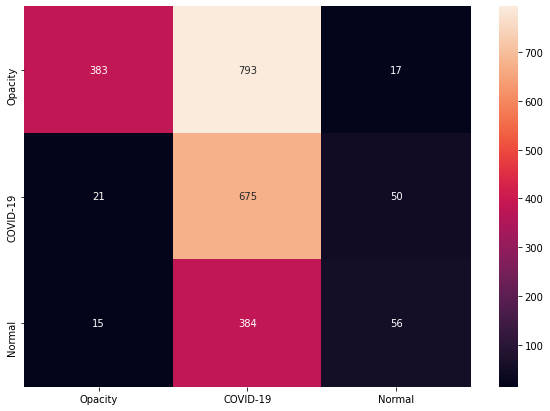

Classification Report
              precision    recall  f1-score   support

     Opacity       0.91      0.32      0.48      1193
    COVID-19       0.36      0.90      0.52       746
      Normal       0.46      0.12      0.19       455

    accuracy                           0.47      2394
   macro avg       0.58      0.45      0.40      2394
weighted avg       0.66      0.47      0.44      2394

F-Score
(0.5779455135876225, 0.4496473522739341, 0.39619607183479766, None)
Accuracy
0.4653299916457811


In [14]:
Y_pred = model.predict(X_test2, batch_size = 6)
y_pred = np.argmax(Y_pred, axis = 1)
y_true = np.argmax(Y_test2, axis = 1)

print('Confusion Matrix')
df_cm_test2 = metrics.confusion_matrix(y_true, y_pred)
cm_labels = ["Opacity", "COVID-19", "Normal"]
cm_array = df_cm_test2
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
plt.figure(figsize = (10,7))
sns.heatmap(cm_array_df, annot=True, fmt='.4g') 
plt.show()




print('Classification Report')
class_repo_test2 = metrics.classification_report(y_true, y_pred, output_dict=True, target_names = ["Opacity", "COVID-19", "Normal"])
print(metrics.classification_report(y_true, y_pred, target_names = ["Opacity", "COVID-19", "Normal"]))
print('F-Score')
f_score_test2 = metrics.precision_recall_fscore_support(y_true, y_pred, average = "macro")
print(f_score_test2)
print("Accuracy")
acc_test2 = metrics.accuracy_score(y_true, y_pred)
print(acc_test2)


## Load prior times

In [15]:
with open('input/time_train.txt', 'r') as file:
    t1 = file.read().rstrip()
    
with open('input/time_train_2.txt', 'r') as file:
    t2 = file.read().rstrip()

In [16]:
t1

'5073.760390996933'

In [17]:
float(t2)

11100.454421520233

In [18]:
tfinal = float(t1) + float(t2)

In [19]:
import datetime

## Send Bot Msg

In [20]:
time_hours = str(datetime.timedelta(seconds=tfinal))
time_hours2 = str(datetime.timedelta(seconds=final_test))

bot.send_message("-600800507", f'Rede {model_name} - Treinamento Finalizado em {time_hours}')
bot.send_message("-600800507", f'Rede {model_name} - Predição Finalizada em {time_hours2}')
bot.send_message("-600800507", f'Acurácia de teste: {acc_test}')

{'ok': True,
 'result': {'message_id': 529,
  'from': {'id': 2058519653,
   'is_bot': True,
   'first_name': 'cnn_covid',
   'username': 'cnn_covid_bot'},
  'chat': {'id': -600800507,
   'title': 'covid accuracy - cnn',
   'type': 'group',
   'all_members_are_administrators': True},
  'date': 1645666516,
  'text': 'Acurácia de teste: 0.9313915857605178'}}

## Save Data

In [21]:
n_epochs = 150
drop = 0.5
IMG_SIZE = (300,300,3)
ind = 1

#csv_columns = ["model", "num of layers retrain", "accuracy_test", "accuracy_train", "accuracy_val", "img_size", "seed", "precision_COVID-19", "recall_COVID-19", "f1_COVID-19",  "precision_Normal", "recall_Normal", "f1_Normal", "precision_Opacity", "recall_Opacity", "f1_Opacity",  "confusion matrix", "epochs", "augmentation", "base_learn_rate", "dropout", "opt"]

#old_csv = pd.read_csv("output/models_evaluation.csv", sep=';')

#old_csv.columns = csv_columns
    
csv = pd.DataFrame()
csv["model"] = [model_name]
csv["base"] = ["Cohen-RICORD-Kaggle-RSNA"]
csv["tempo_treino"] = tfinal
csv["tempo_pred"] = final_test
csv["full_retrain"] = True
csv["accuracy_test"] = [acc_test]
csv["accuracy_test_diff"] = [acc_test2]
csv["accuracy_train"] = [acc_train]
csv["accuracy_val"] = [acc_val]
csv["img_size"] = [IMG_SIZE]
csv["seed"] = [587]
    
csv["precision_COVID-19"] = [class_repo_test['COVID-19']["precision"]]
csv["recall_COVID-19"] = [class_repo_test['COVID-19']["recall"]]
csv["f1_COVID-19"] = [class_repo_test['COVID-19']["f1-score"]]
    
csv["precision_Normal"] = [class_repo_test['Normal']["precision"]]
csv["recall_Normal"] = [class_repo_test['Normal']["recall"]]
csv["f1_Normal"] = [class_repo_test['Normal']["f1-score"]]
    
csv["precision_Opacity"] = [class_repo_test['Opacity']["precision"]]
csv["recall_Opacity"] = [class_repo_test['Opacity']["recall"]]
csv["f1_Opacity"] = [class_repo_test['Opacity']["f1-score"]]


csv["Class_Repo_Train"] = [class_repo_train]
csv["Class_Repo_Val"] = [class_repo_val]
csv["Class_Repo_Test"] = [class_repo_test]
csv["Class_Repo_Test_diff"] = [class_repo_test2]

csv["F_Score_Train"] = [f_score_train]
csv["F_Score_Val"] = [f_score_val]
csv["F_Score_Test"] = [f_score_test]
csv["F_Score_Test_diff"] = [f_score_test2]
 
    
csv["confusion_matrix_train"] = [df_cm_train]    
csv["confusion_matrix_val"] = [df_cm_val]    
csv["confusion_matrix_test"] = [df_cm_test]
csv["confusion_matrix_test_diff"] = [df_cm_test2]

csv["epochs"] = [n_epochs]
csv["augmentation"] = ["simple"]
csv["dropout"] = [drop]
csv["opt"] = "Adam"
    
csv["base_learn_rate"] = [0.001]
csv["id"] = ind

#new_csv = pd.concat([old_csv, csv])

new_csv = csv

new_csv.to_csv("output/models_evaluation.csv", index=False, sep=';')

## ROC Curve

In [22]:
tf.keras.backend.clear_session()
model = keras.models.load_model(model_name)

Y_pred = model.predict(X_test, batch_size = 16)

i = 1
fpr, tpr, thresholds = roc_curve(Y_test[:, i], Y_pred[:, i])
data = {'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds}
df = pd.DataFrame(data)
df.to_csv(f"output/nonsegmented_vgg16_roc_{ind}.csv", index = False)